In [3]:
!pip3 install h5py seaborn

You should consider upgrading via the 'C:\Users\yasha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [17]:
import h5py
import numpy as np
from scipy.integrate import odeint
from numpy import sin, cos, pi

def openFile(filename):
    with h5py.File(filename, 'r') as f:
        print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]
        data = list(f[a_group_key])
        axis0_data = list(f[a_group_key]['axis0'])
        axis1_data = list(f[a_group_key]['axis1'])
        block0_items = list(f[a_group_key]['block0_items'])
        block0_values = list(f[a_group_key]['block0_values'])
        separate_arrays = [np.array(array) for array in block0_values]
        
        return {
            'data': data,
            'axis0_data': axis0_data,
            'axis1_data': axis1_data,
            'block0_items': block0_items,
            'block0_values': np.array(separate_arrays),
        }
    
    
data1 = openFile('Data/uni_111.h5')
data2 = openFile('Data/uni_112.h5')
data3 = openFile('Data/uni_113.h5')

Keys: <KeysViewHDF5 ['EEG']>
Keys: <KeysViewHDF5 ['EEG']>
Keys: <KeysViewHDF5 ['EEG']>


In [18]:
print(data1['block0_values'])

[[ 5.21388197e+01  7.60388050e+01  6.90253868e+01 ...  5.96603377e+01
   5.82450226e+01  4.05887058e+01]
 [ 6.90003894e+01  7.95133720e+01  1.14963601e+02 ...  7.80196819e+01
   7.89633340e+01  6.15745931e+01]
 [ 7.18162072e+01  7.60578973e+01  1.30431279e+02 ...  8.52816545e+01
   8.40137605e+01  6.54350226e+01]
 ...
 [-5.09690961e-01 -1.68317817e+00 -3.55121633e+00 ...  7.43748608e-01
   3.57305319e-01 -2.66479713e-02]
 [ 8.71479035e-02 -1.10954660e+00 -2.90077585e+00 ...  1.03520362e+00
   8.08741713e-01  5.64112848e-01]
 [ 7.40186015e-02 -1.12274753e+00 -2.75612269e+00 ...  8.62963036e-01
   6.36846890e-01  3.24022190e-01]]


In [19]:
def dataAnalysis(data):
    print("There are %d electrode planes from which data is collected" % len(data['axis0_data']))
    print("There are %d signals collected from each electrode plane" % len(data['axis1_data']))
    print("With frequency of 200 signals in a second, the data is collected in %.2f minutes or %d seconds" % (len(data['axis1_data'])/60/200, len(data['axis1_data'])/200))
    print("-----------------------------------------------------")

dataAnalysis(data1)
dataAnalysis(data2)
dataAnalysis(data3)
       

There are 44 electrode planes from which data is collected
There are 94800 signals collected from each electrode plane
With frequency of 200 signals in a second, the data is collected in 7.90 minutes or 474 seconds
-----------------------------------------------------
There are 44 electrode planes from which data is collected
There are 101200 signals collected from each electrode plane
With frequency of 200 signals in a second, the data is collected in 8.43 minutes or 506 seconds
-----------------------------------------------------
There are 44 electrode planes from which data is collected
There are 109600 signals collected from each electrode plane
With frequency of 200 signals in a second, the data is collected in 9.13 minutes or 548 seconds
-----------------------------------------------------


### Correlation between channnels 44x44

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

def dfs(v, visited, adj):
    visited[v] = True
    for i in range(len(adj[v])):
        if visited[adj[v][i]] == False:
            dfs(adj[v][i], visited, adj)

def isConnected(adj, V):
    visited = [False] * V
    dfs(0, visited, adj)
    for i in range(V):
        if visited[i] == False:
            return False
    return True

def createCorrelationMatrix(data, start, end):
    block_data = data['block0_values']
    reshaped_data = block_data.reshape(-1, block_data.shape[1])
    correlation_matrix = np.corrcoef(block_data[start:end].T)
    correlation_matrix = np.abs(correlation_matrix)
    # make it a binary matrix
    low, high = 0, 1
    threshold = 1
    while high - low > 1e-6:  # precision of threshold
        mid = (low + high) / 2
        temp_matrix = correlation_matrix.copy()
        temp_matrix[temp_matrix < mid] = 0
        temp_matrix[temp_matrix >= mid] = 1
        # make the diagonal 0
        np.fill_diagonal(temp_matrix, 0)
        # make lower triangle 0
        # temp_matrix = np.tril(temp_matrix, k=-1)
        adj = [list(np.where(row == 1)[0]) for row in temp_matrix]
        if isConnected(adj, len(temp_matrix)):
            low = mid
            threshold = mid
        else:
            high = mid
        channel_names = data['block0_items']

    correlation_matrix[correlation_matrix < threshold] = 0
    correlation_matrix[correlation_matrix >= threshold] = 1
    np.fill_diagonal(correlation_matrix, 0)
    return correlation_matrix


In [47]:
S = 5000
def calculateMetrics(adj):
    clustering_coefficients = []
    for node in range(len(adj)):
        neighbors = adj[node]
        if len(neighbors) < 2:
            clustering_coefficients.append(0)
        else:
            edges_between_neighbors = sum(1 for neighbor in neighbors if neighbor in adj[node])
            clustering_coefficients.append(edges_between_neighbors / (len(neighbors) * (len(neighbors) - 1) / 2))
    avg_clustering_coefficient = sum(clustering_coefficients) / len(clustering_coefficients)

    # Calculate average path length
    path_lengths = []
    for node in range(len(adj)):
        visited = [False] * len(adj)
        queue = [(node, 0)]
        visited[node] = True
        while queue:
            current_node, depth = queue.pop(0)
            path_lengths.append(depth)
            for neighbor in adj[current_node]:
                if not visited[neighbor]:
                    queue.append((neighbor, depth + 1))
                    visited[neighbor] = True
    avg_path_length = sum(path_lengths) / len(path_lengths)

    # Calculate average degree
    degrees = [len(neighbors) for neighbors in adj]
    avg_degree = sum(degrees) / len(degrees)

    return avg_clustering_coefficient, avg_path_length, avg_degree

def plot_data(data, start, end, title, frequency=200):
    time = [(i+0.5)*S/frequency for i in range(len(data))]
    start_time = start 
    end_time = end 

    plt.figure(figsize=(10, 6))
    plt.plot(time, data, label=title)
    plt.axvline(x=start_time, color='r', linestyle='--')
    plt.axvline(x=end_time, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()

class Kuramoto:

    def __init__(self, coupling=1, dt=0.01, T=10, n_nodes=None, natfreqs=None):
        if n_nodes is None and natfreqs is None:
            raise ValueError("n_nodes or natfreqs must be specified")

        self.dt = dt
        self.T = T
        self.coupling = coupling

        if natfreqs is not None:
            self.natfreqs = natfreqs
            self.n_nodes = len(natfreqs)
        else:
            self.n_nodes = n_nodes
            self.natfreqs = np.random.random(size=n_nodes)

    def init_angles(self):
        return 2 * np.pi * np.random.random(size=self.n_nodes)

    def derivative(self, angles_vec, t, adj_mat, coupling):
        angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
        interactions = adj_mat * np.sin(angles_j - angles_i)  

        dxdt = self.natfreqs + coupling * interactions.sum(axis=0)  
        return dxdt

    def integrate(self, angles_vec, adj_mat):
        n_interactions = (adj_mat != 0).sum(axis=0)  

        coupling = self.coupling / n_interactions 

        t = np.linspace(0, self.T, int(self.T/self.dt))
        timeseries = odeint(self.derivative, angles_vec, t, args=(adj_mat, coupling))
        return timeseries.T 

    def run(self, adj_mat=None, angles_vec=None):
        if angles_vec is None:
            angles_vec = self.init_angles()

        return self.integrate(angles_vec, adj_mat)

    @staticmethod
    def phase_coherence(angles_vec):
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

    def mean_frequency(self, act_mat, adj_mat):
        _, n_steps = act_mat.shape
        dxdt = np.zeros_like(act_mat)
        for time in range(n_steps):
            dxdt[:, time] = self.derivative(act_mat[:, time], None, adj_mat)
        integral = np.sum(dxdt * self.dt, axis=1)
        meanfreq = integral / self.T
        return meanfreq

import networkx as nx

def analyzeData(data, start, end, chunk_size=S):
    num_chunks = len(data['block0_values']) // chunk_size
    avg_clustering_coefficients = []
    avg_path_lengths = []
    avg_degrees = []
    synchronizations = []
    for i in range(num_chunks):
        corr_mat_binary = createCorrelationMatrix(data, i * chunk_size, (i + 1) * chunk_size)
        adj = [list(np.where(row == 1)[0]) for row in corr_mat_binary]
        avg_clustering_coefficient, avg_path_length, avg_degree = calculateMetrics(adj)
        avg_clustering_coefficients.append(avg_clustering_coefficient)
        avg_path_lengths.append(avg_path_length)
        avg_degrees.append(avg_degree)
        
        sns.set_style("whitegrid")
        sns.set_context("notebook", font_scale=1.6)
        model = Kuramoto(coupling=2, dt=0.01, T=10, n_nodes=len(corr_mat_binary))
        activity = model.run(adj_mat=corr_mat_binary)
        phase_coherence = [model.phase_coherence(activity[:, i]) for i in range(activity.shape[1])]
        #push the average of last 50 coherence values to the synchronizations list
        synchronizations.append(np.mean(phase_coherence[-50:]))
        if(i == 0):
            plt.figure(figsize=(10, 6))
            plt.plot(activity.T)
            plt.title("Activity of the Kuramoto model")
            plt.xlabel("Time (s)")
            plt.ylabel("Activity")
            plt.show()

            dthetadt = np.diff(activity, axis=1) / model.dt
            plt.figure(figsize=(10, 6))
            plt.plot(dthetadt.T)
            plt.title("Derivative of the activity of the Kuramoto model")
            plt.xlabel("Time (s)")
            plt.ylabel("Derivative")
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.plot(phase_coherence)
            plt.title("Phase coherence of the Kuramoto model")
            plt.xlabel("Time (s)")
            plt.ylabel("Phase coherence")
            plt.show()
    plot_data(avg_clustering_coefficients, start, end, 'Average Clustering Coefficient')
    plot_data(avg_path_lengths, start, end, 'Average Path Length')
    plot_data(avg_degrees, start, end, 'Average Degree')
    plot_data(synchronizations, start, end, 'Synchronization')
    
    plt.show()


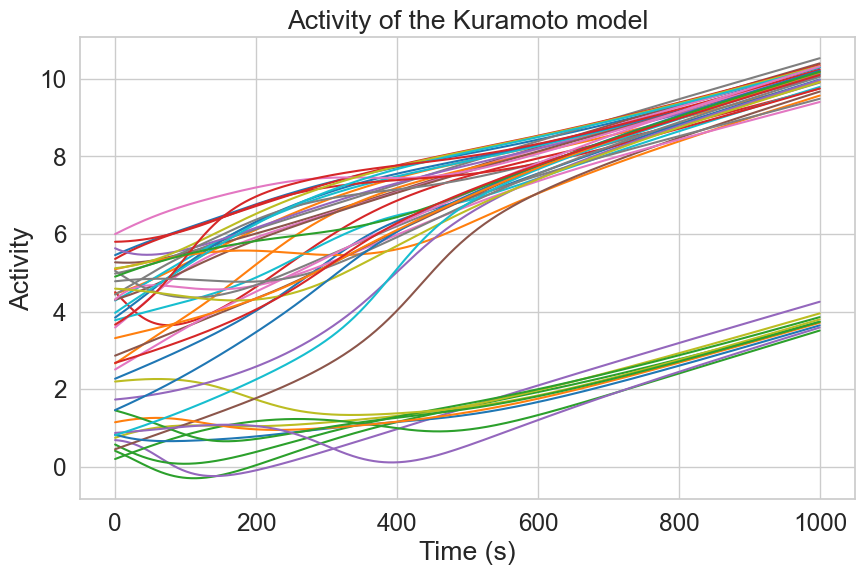

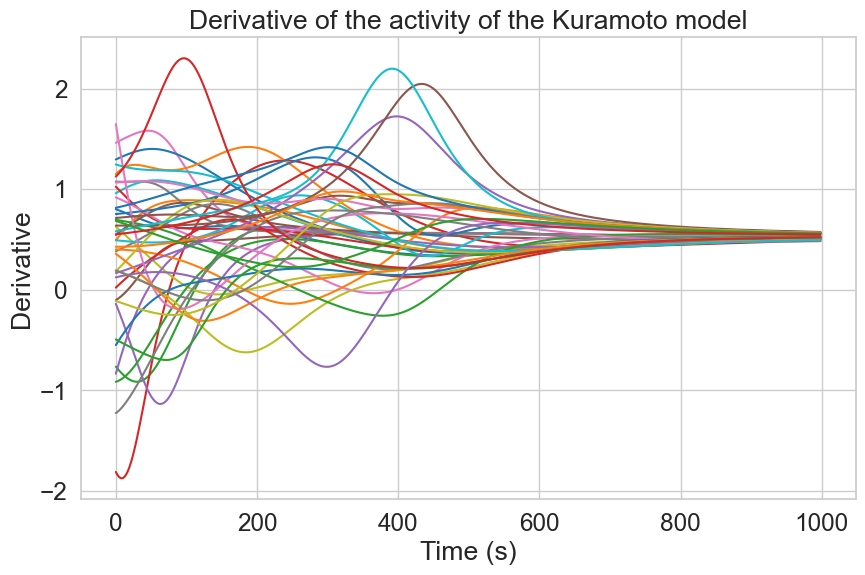

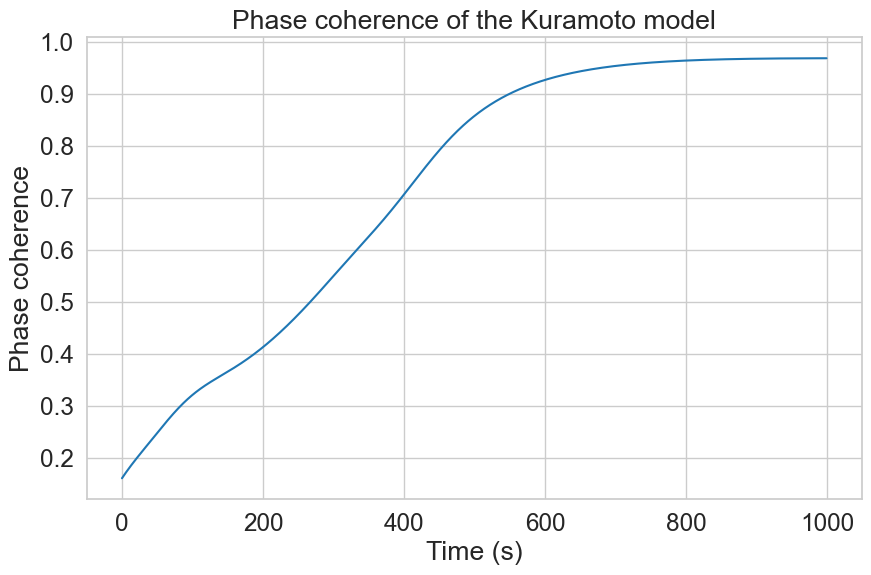

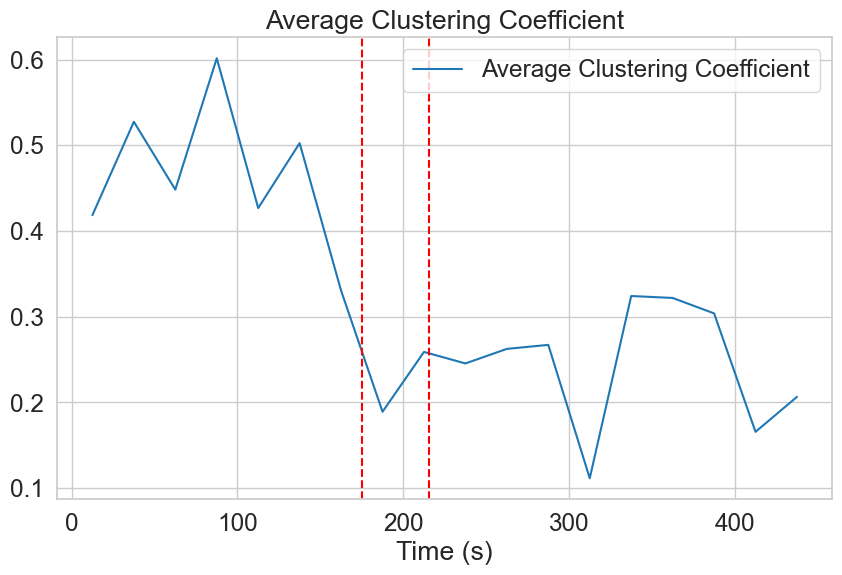

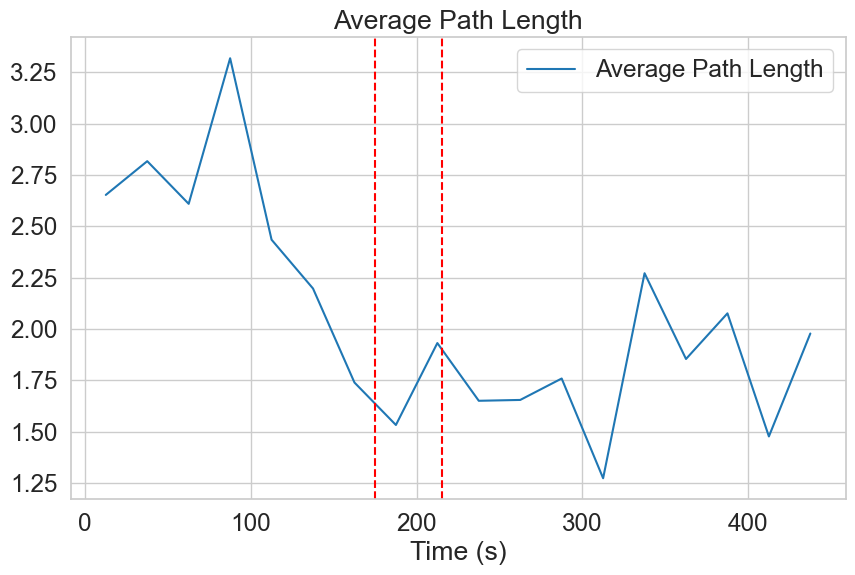

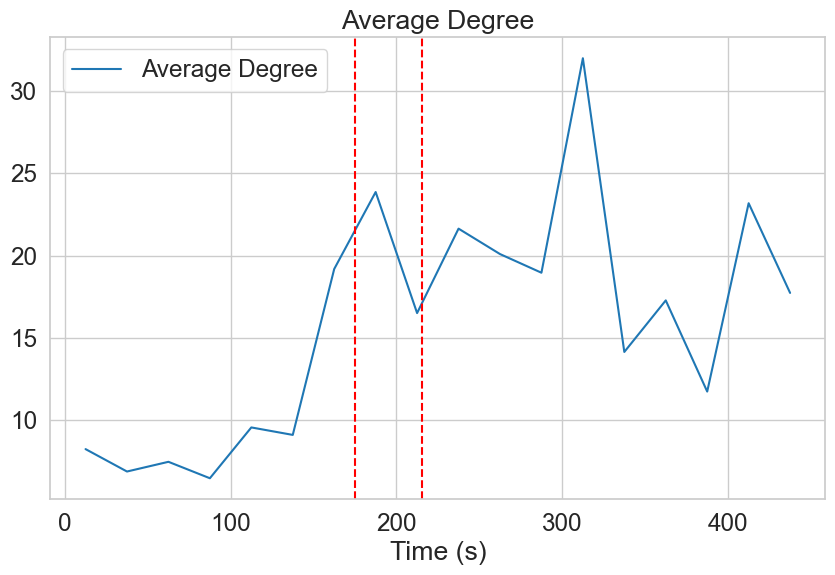

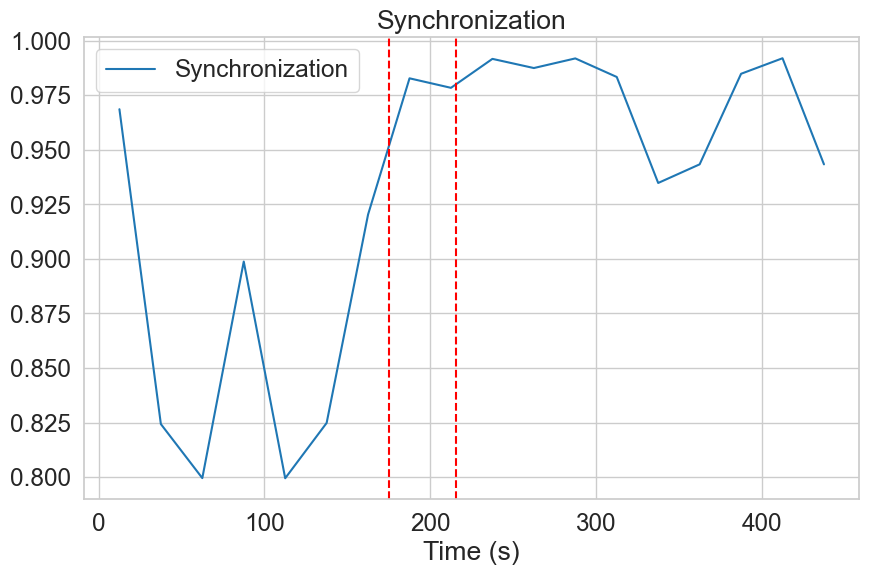

In [48]:
analyzeData(data1, 174.87, 215.505)

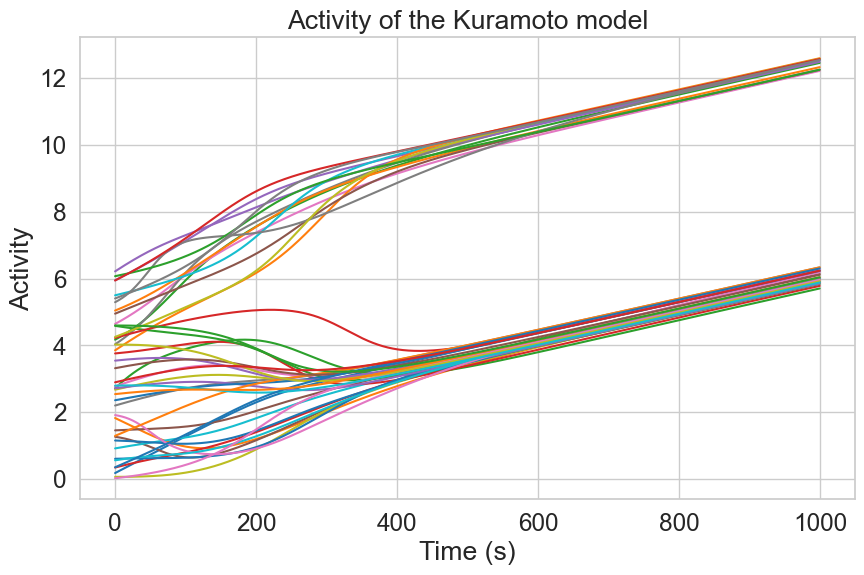

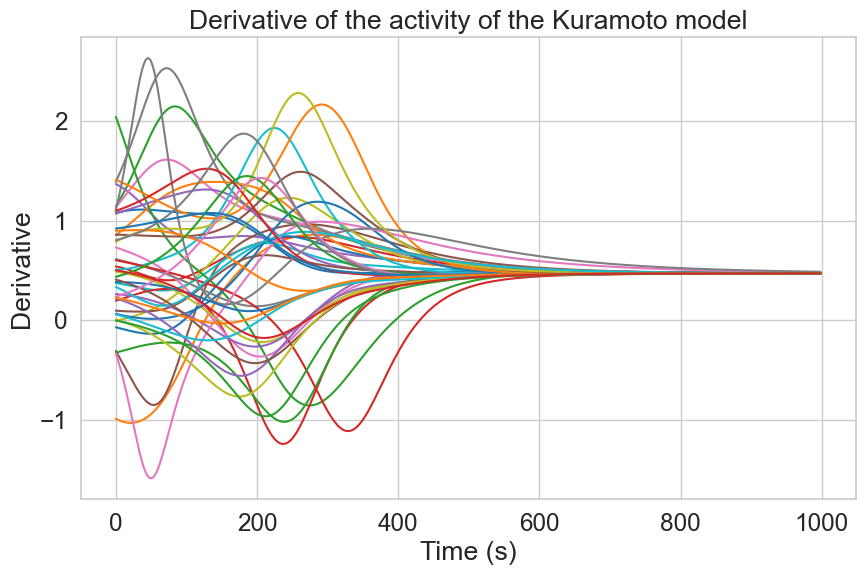

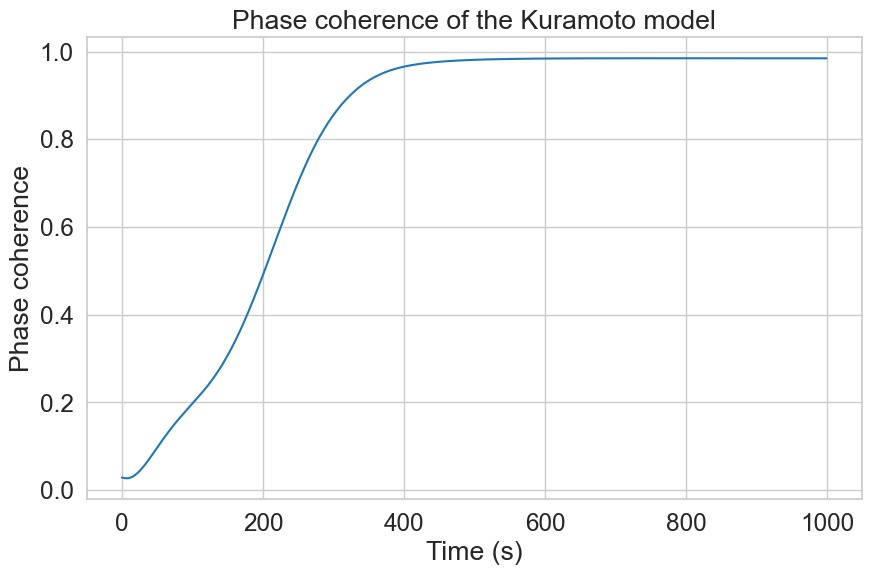

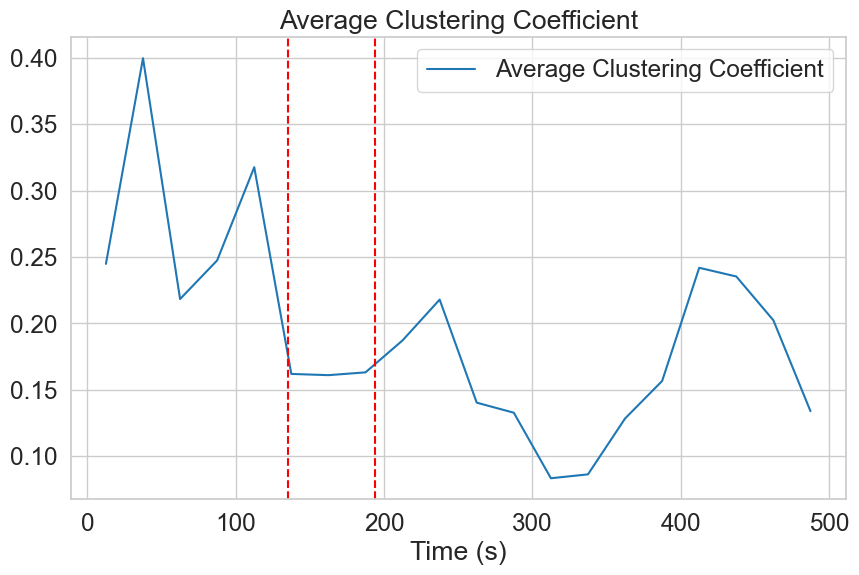

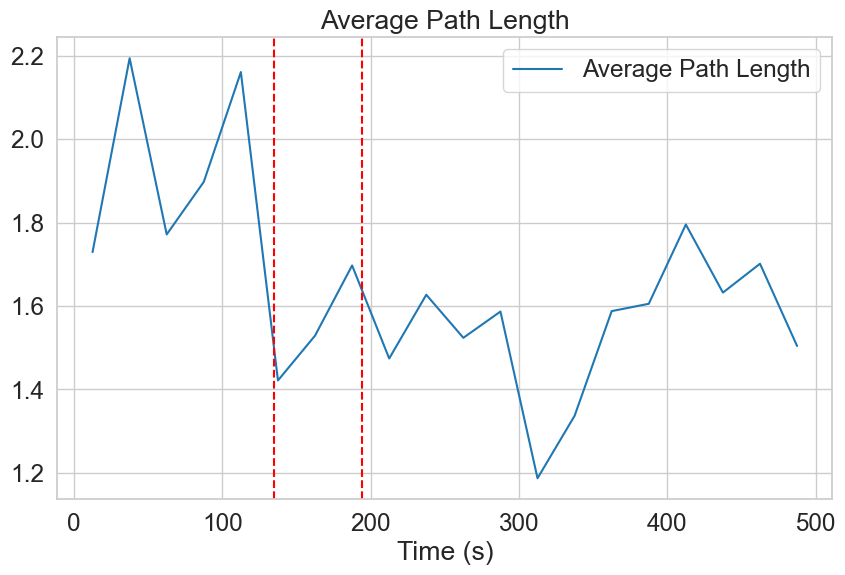

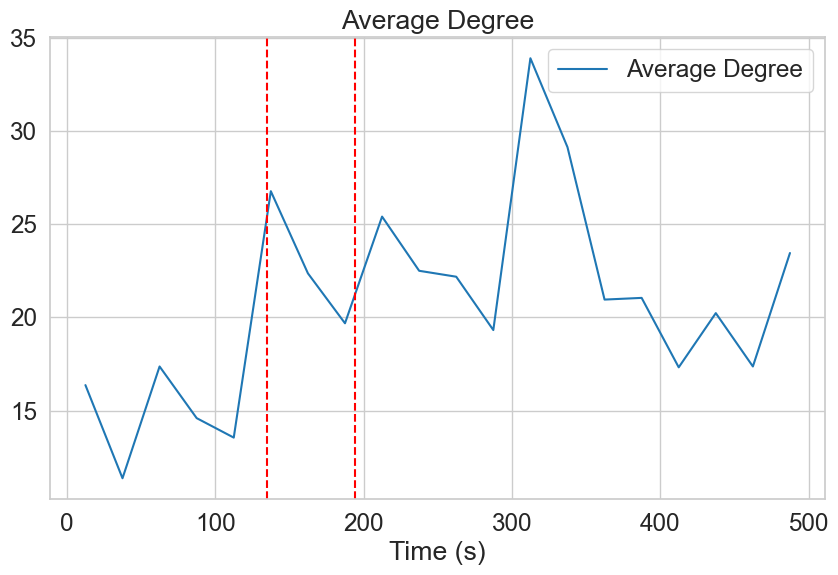

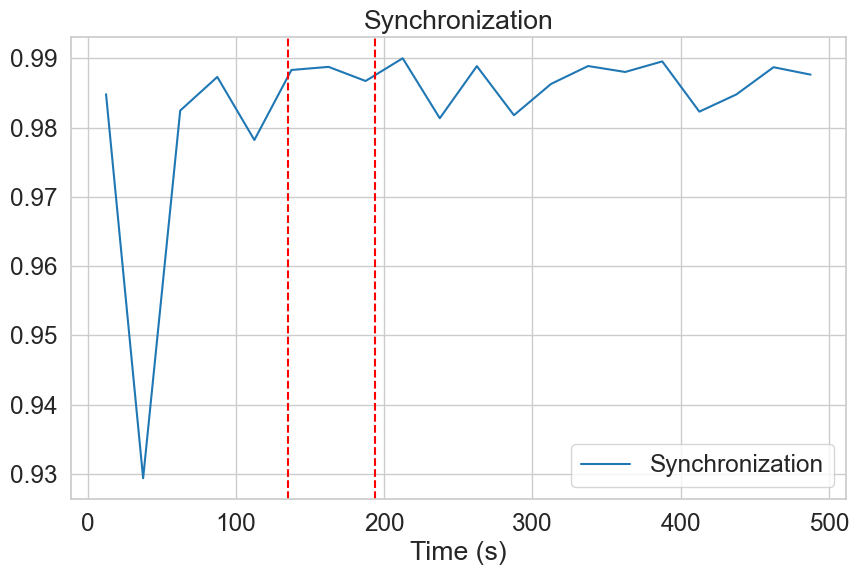

In [49]:
analyzeData(data2, 134.995, 194.14)

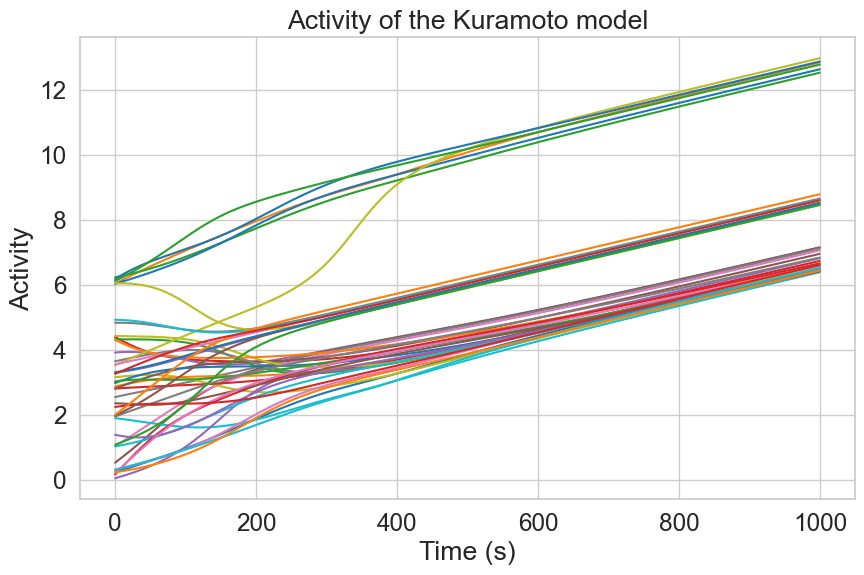

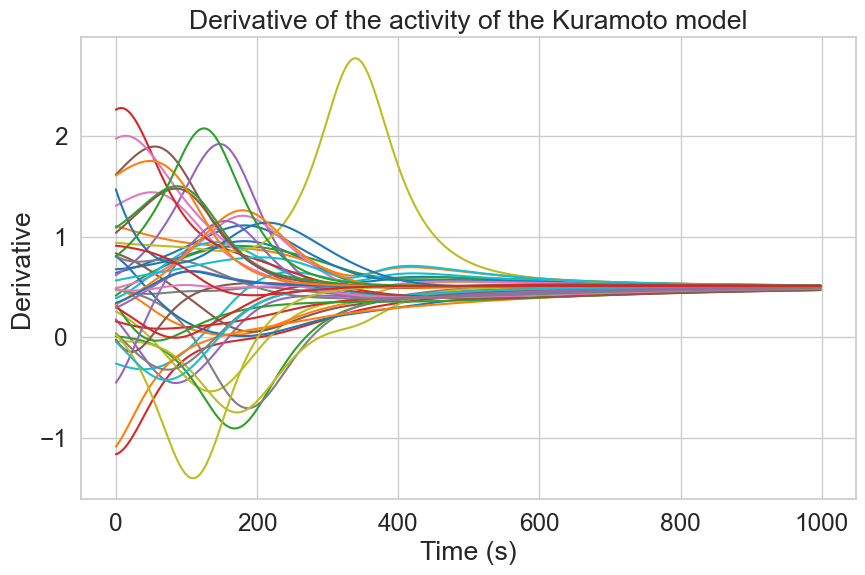

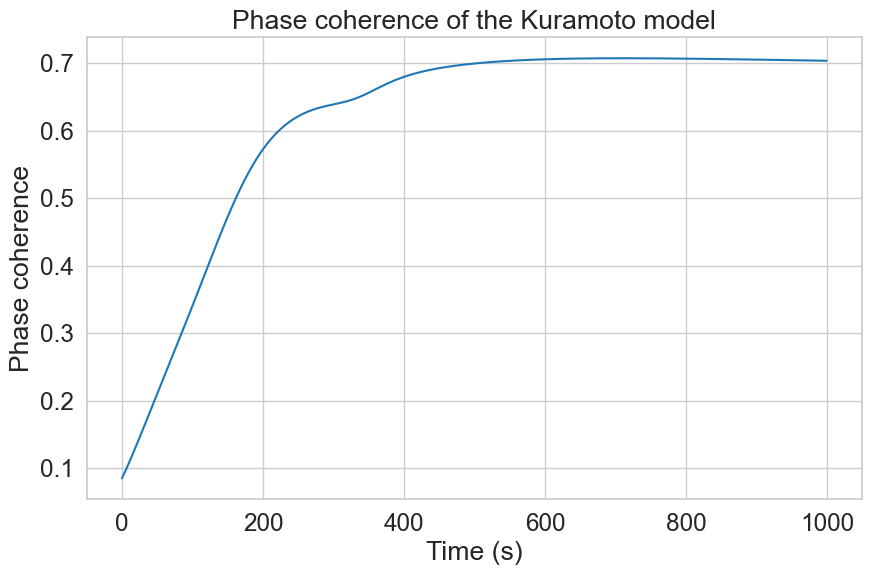

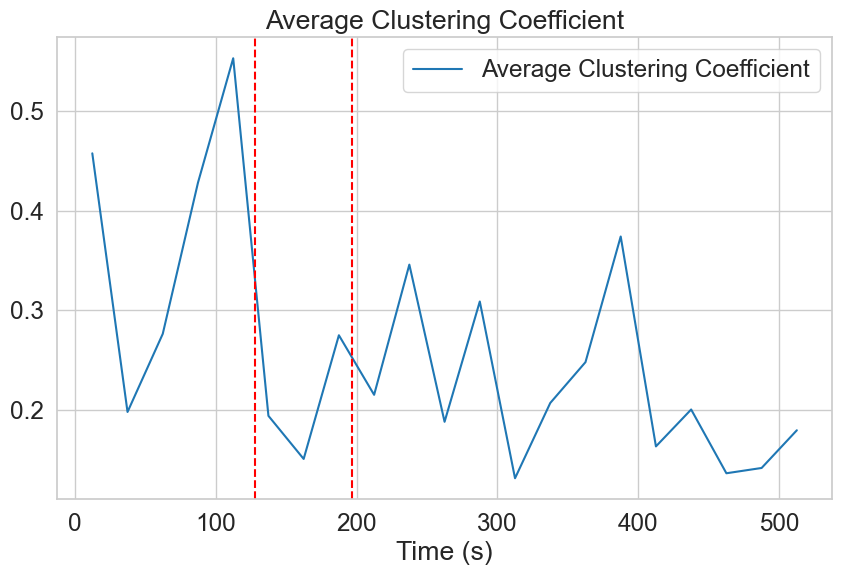

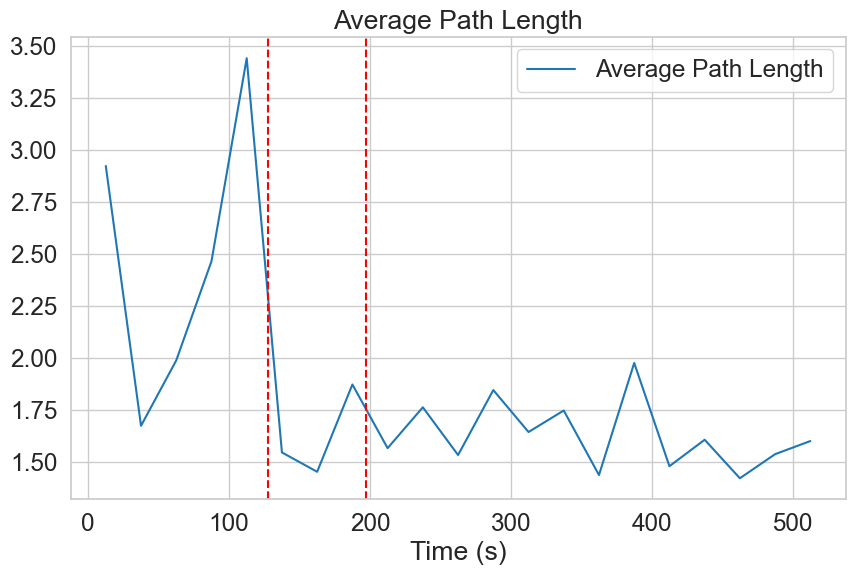

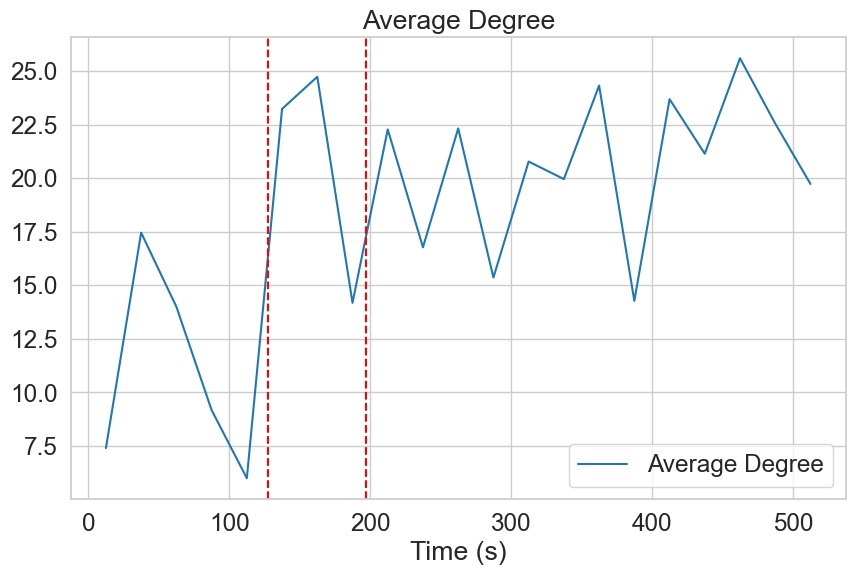

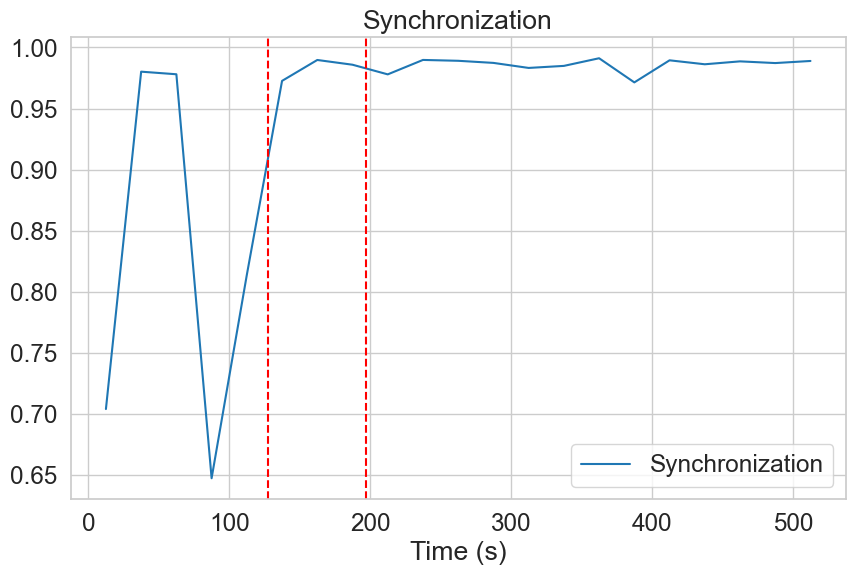

In [50]:

analyzeData(data3, 127.81, 197.1)

C:\Users\yasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


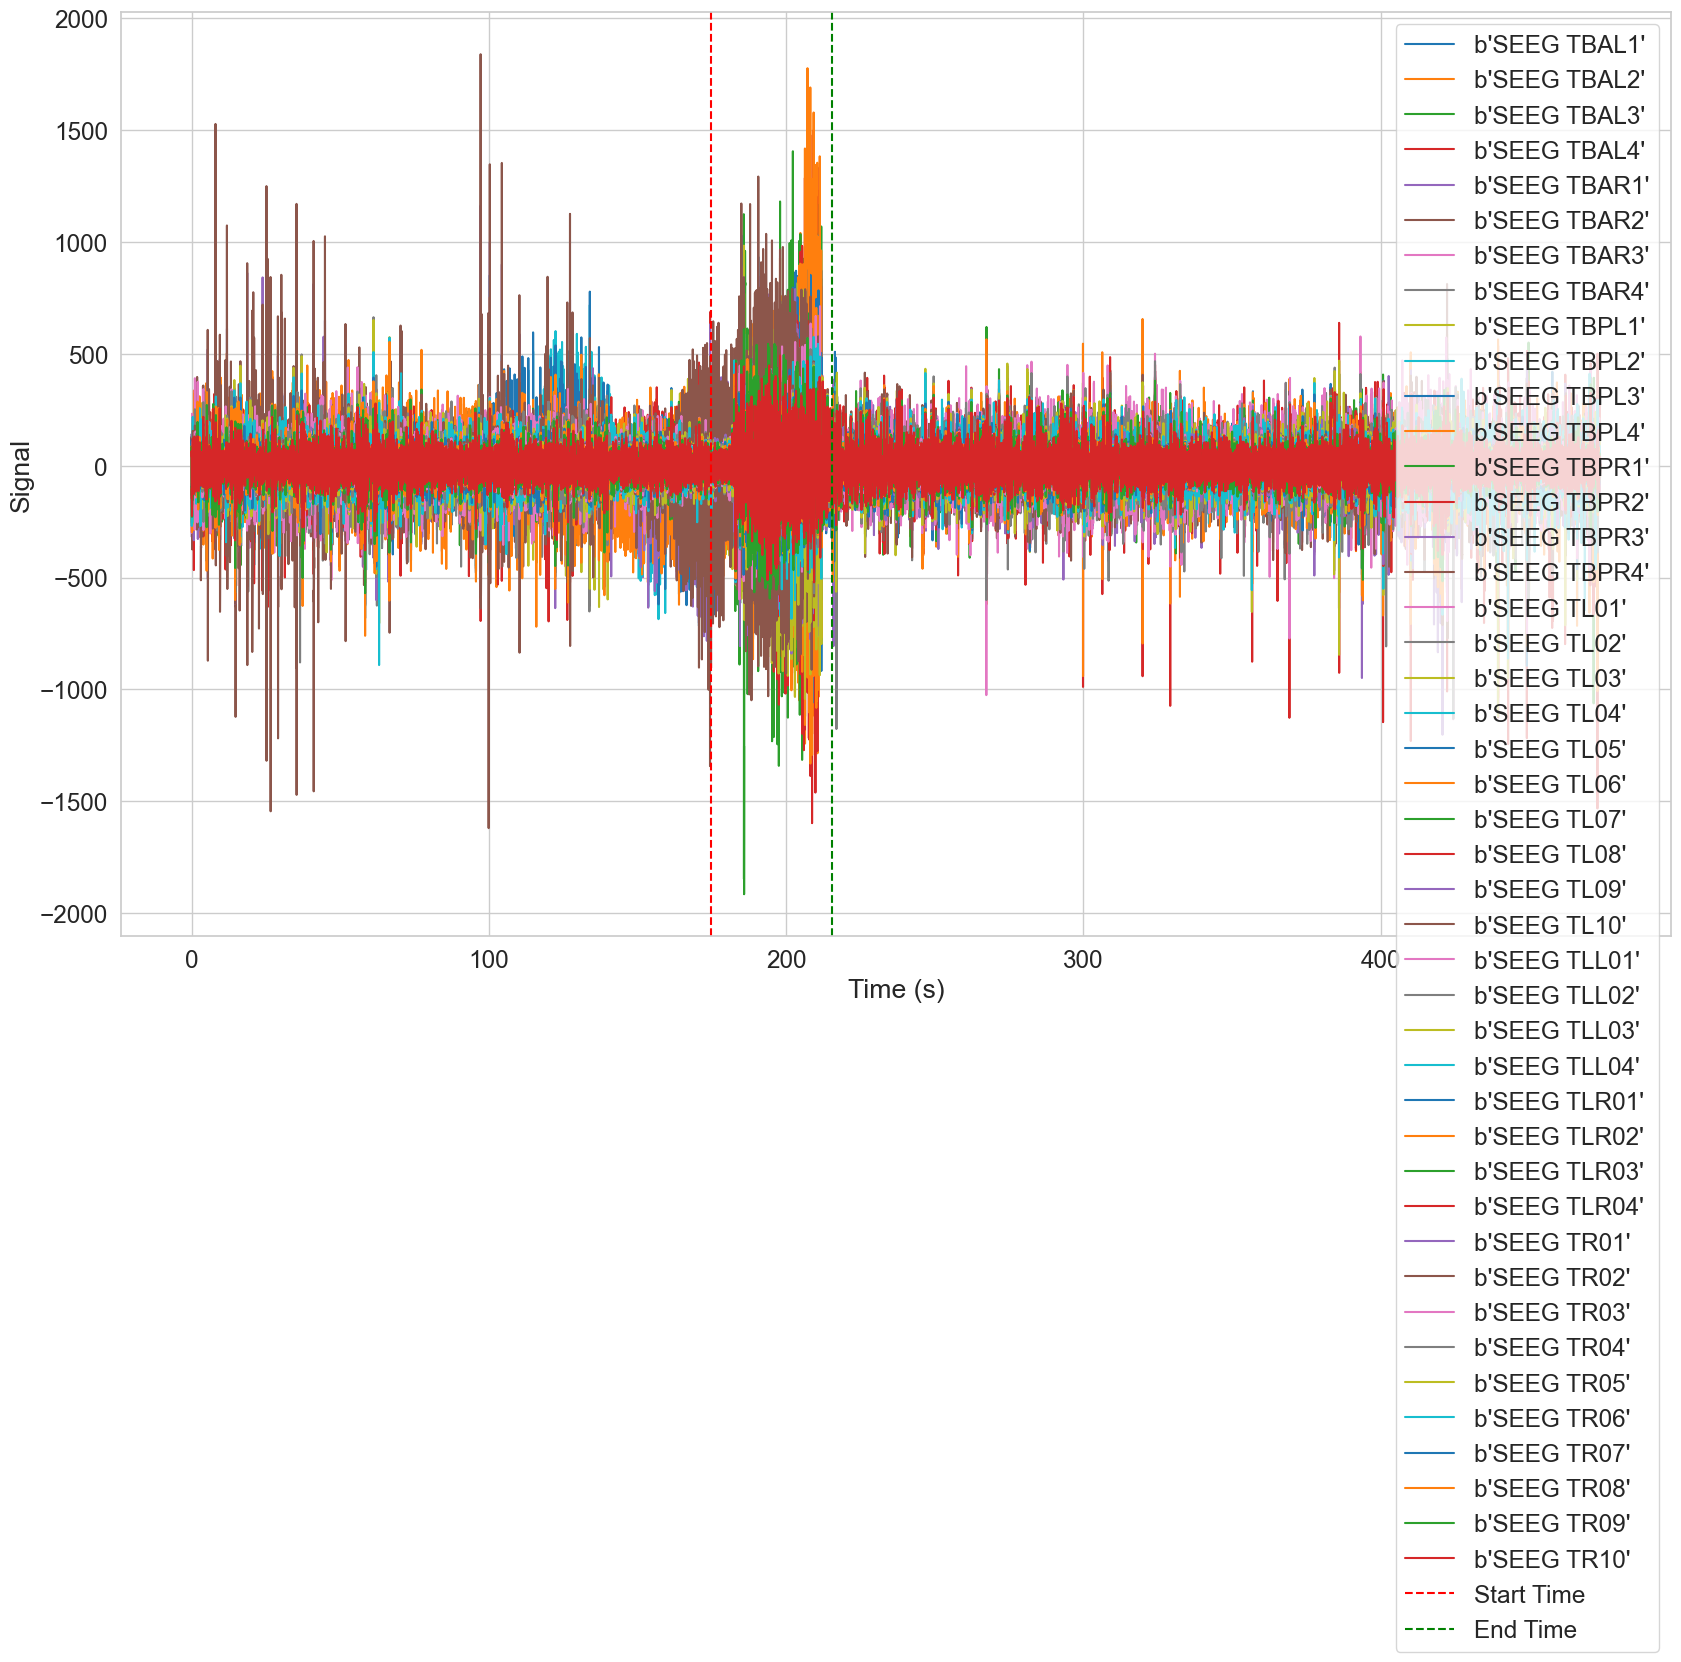

In [51]:
def create_time_series_plot(data, vertical_lines):
    start_time, end_time = vertical_lines
    block_data = data['block0_values']
    # calculate the time axis 
    time_axis = np.arange(0, len(data['axis1_data'])/200, 1/200)
    # plot the time series
    plt.figure(figsize=(20, 12))
    for i in range(block_data.shape[1]):
        plt.plot(time_axis, block_data[:, i], label=data['block0_items'][i])
    # plot the vertical lines
    plt.axvline(x=start_time, color='r', linestyle='--', label='Start Time')
    plt.axvline(x=end_time, color='g', linestyle='--', label='End Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()

create_time_series_plot(data1, [174.87, 215.505])


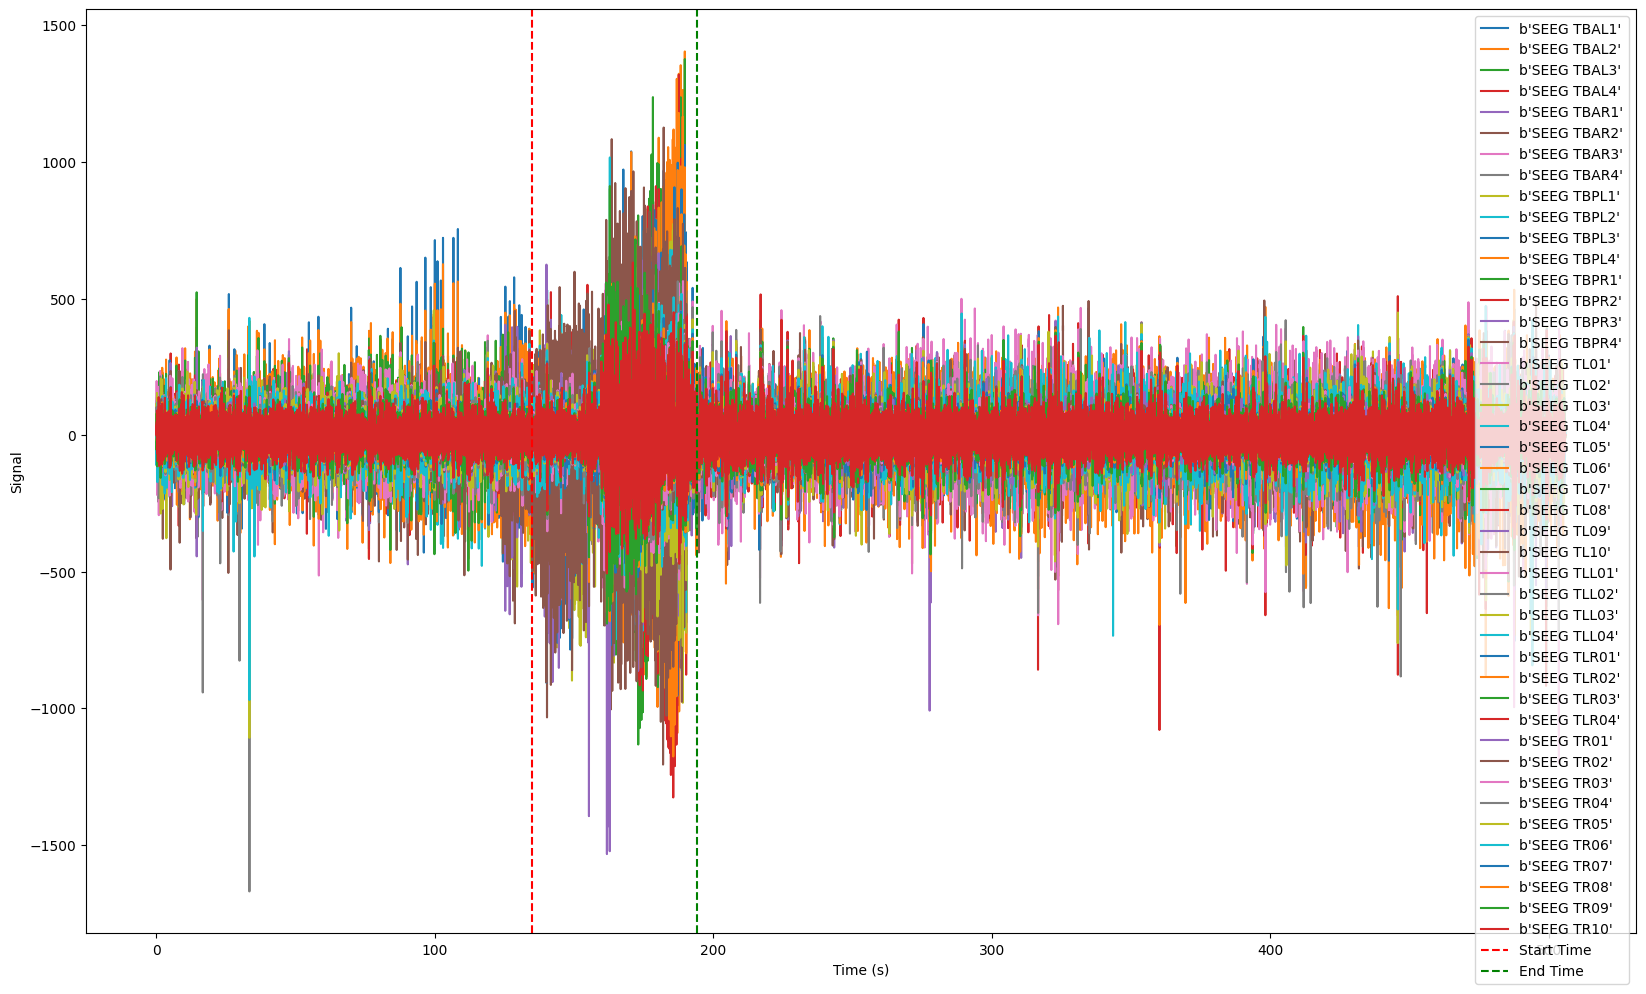

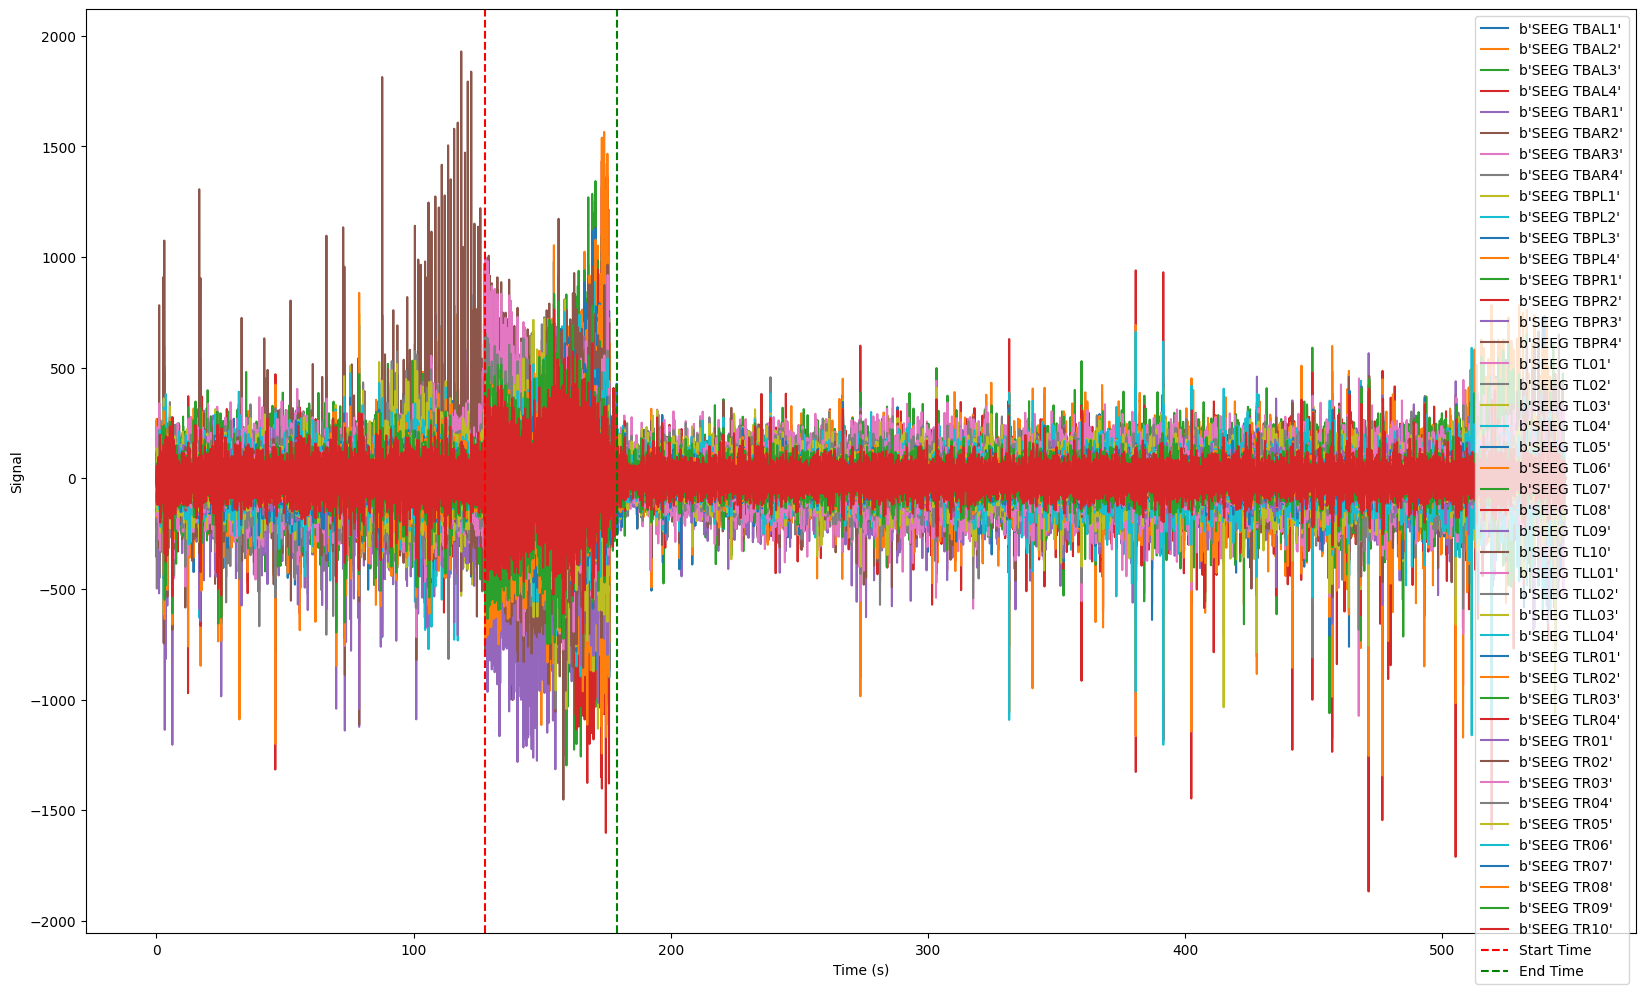

In [ ]:
create_time_series_plot(data2, [134.995, 194.14])
create_time_series_plot(data3, [127.81, 179.1])